In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

In [11]:
def factor_function(sigma_i, i_neighbour, i_neighbour2, sigma_j, j_neighbour, j_neighbour2, permutation, d):
    final = 1
    total = 0
    
    if sigma_i == 1:
        total = sigma_j + j_neighbour + j_neighbour2 + i_neighbour + i_neighbour2 + np.sum(permutation)
        if total == 0:
            final *= 1
        else:
            return 0
    
    # if sigma_i == 0:
    #     if np.sum(first_neighbours) > 1:
    #         return 0
    #     for idx, neighbours in enumerate(second_neighbours):
    #         if np.sum(neighbours) + first_neighbours[idx] > 1:
    #             return 0
    
    return final

In [12]:
def BP(d, mu=0, tol=1e-12, max_iter=10000, damping_parameter=0.8, verbose=0, init_psi=None):
    psi=np.zeros((2, 2, 2, 2, 2, 2))
    if init_psi is None:
        psi=np.random.uniform(size=(2, 2, 2, 2, 2, 2))
        psi=psi/np.sum(psi)
    else:
        psi=init_psi.copy()
    
    permutations=np.array(list(itertools.product([0,1], repeat=4)))
    
    for t in range(max_iter):
        psi_new=np.zeros((2, 2, 2, 2, 2, 2))
        for i in range(2):
            for i_neighbour in range(2):
                for i_neighbour2 in range(2):
                    for j in range(2):
                        for j_neighbour in range(2):
                            for j_neighbour2 in range(2):
                                for perm in permutations:
                                    mult=1
                                    if factor_function(i, i_neighbour, i_neighbour2, j, j_neighbour, j_neighbour2, perm, d)==0:
                                        continue
                                    #for _ in range(2): #mudar para degree
                                    mult*=psi[i_neighbour, perm[0], perm[1], i, j, i_neighbour2]
                                    mult*=psi[i_neighbour2, perm[2], perm[3], i, j, i_neighbour]
                                    psi_new[i, i_neighbour, i_neighbour2, j, j_neighbour, j_neighbour2]+=np.exp(mu*i)*mult
                    
        if np.sum(psi_new)!=0:
            psi_new=psi_new/np.sum(psi_new)
        else:
            psi_new=np.ones((2, 2, 2, 2, 2, 2))/64
        
        psi_new=damping_parameter*psi+(1-damping_parameter)*psi_new
        
        Delta=np.linalg.norm(psi_new-psi)
        if verbose==2 and t%100==0:
            print("Iter : ", t+1, " Delta : ", Delta)
        psi=psi_new
        if Delta<tol:
            break
    
    if t==max_iter-1:
        print("No convergence"+" ! Final error: "+ str(Delta))
    else:
        if verbose>=1:
            print("Converged ! Number of iteration "+str(t))
    
    return psi

In [15]:
def update_observables(psi, mu, d=3):
        phi_=0
        phi__=0

        permutations=np.array(list(itertools.product([0,1], repeat=4)))
        
        numerator=0
        
        for i in range(2):
            for i_neighbour in range(2):
                for i_neighbour2 in range(2):
                    for j in range(2):
                        for j_neighbour in range(2):
                            for j_neighbour2 in range(2):
                                for perm in permutations:
                                    mult=1
                                    if factor_function(i, i_neighbour, i_neighbour2, j, j_neighbour, j_neighbour2, perm, d)==0:
                                        continue
                                    mult*=psi[i_neighbour, perm[0], perm[1], i, j, i_neighbour2]
                                    mult*=psi[i_neighbour2, perm[2], perm[3], i, j, i_neighbour]
                                    mult*=psi[j, j_neighbour, j_neighbour2, i, i_neighbour, i_neighbour2]
                                    phi_+=np.exp(mu*i)*mult
                                    numerator+=i*mult*np.exp(mu*i)
                                    
                                phi__+=psi[i, i_neighbour, i_neighbour2, j, j_neighbour, j_neighbour2]*psi[j, j_neighbour, j_neighbour2, i, i_neighbour, i_neighbour2]

        if phi_==0:
            phi_=1e-16
        if phi__==0:
            phi__=1e-16
        phi=np.log(phi_)-d/2*np.log(phi__)

        if numerator==0:
            rho=0
        else:
            rho=numerator/phi_
            
        s=phi-mu*rho

        return phi, rho, s

In [16]:
mu_space = np.linspace(0, 12, 100)
d = 3
phi_list = []
rho_list = []
s_list = []
for mu in tqdm(mu_space):
    psi = BP(d, mu=mu, verbose=0)
    phi, rho, s = update_observables(psi, mu, d)
    phi_list.append(phi)
    rho_list.append(rho)
    s_list.append(s)

100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


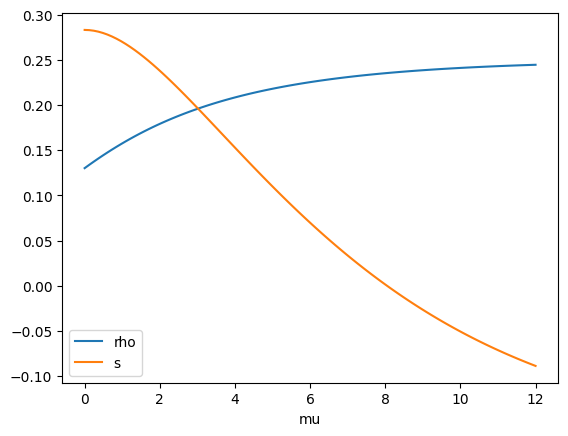

In [17]:
plt.plot(mu_space, rho_list, label='rho')
plt.plot(mu_space, s_list, label='s')
plt.xlabel('mu')
plt.legend()
plt.show()

In [18]:
print(s_list[0])

0.2833081494569667


In [19]:
def find_zero_bisection(arr):
    # Function to find zero using bisection method
    left = 0
    right = len(arr) - 1
    if(arr[left]*arr[right] > 0):
        print("No zero crossing found")
        return -1

    while right - left > 1:
        mid = (left + right) // 2
        if arr[mid] == 0:
            return mid  # Zero found at index 'mid'
        elif arr[mid] * arr[left] < 0:
            right = mid
        else:
            left = mid

    # If exact zero not found, return the index closest to zero
    return left if abs(arr[left]) < abs(arr[right]) else right

In [21]:
find_zero_bisection(s_list)
print(rho_list[find_zero_bisection(s_list)])

0.23537704289905934
